# Quick Start With Public Datasets and add new Dataset

In this tutorial, we introduce how to quickly set up workflows with MONAI public Datasets and how to add new Dataset.  
Currently, MONAI provides `MedNISTDataset` and `DecathlonDataset` to automatically download and extract  
the MedNIST and Decathlon datasets, and act as PyTorch datasets to generate training/validation/test data.

We'll cover the following topics in this tutorial:
* Create training experiment with MedNISTDataset and workflow
* Create training experiment with DecathlonDataset and workflow
* Share other public data and add Dataset in MONAI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/public_datasets.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
from monai.transforms import (
    AddChanneld,
    AsDiscreted,
    Compose,
    LoadImaged,
    Orientationd,
    Randomizable,
    Resized,
    ScaleIntensityd,
    Spacingd,
    EnsureTyped,
)
from monai.networks.nets import UNet, DenseNet121
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.inferers import SimpleInferer
from monai.handlers import MeanDice, StatsHandler, from_engine
from monai.engines import SupervisedTrainer
from monai.data import CacheDataset, DataLoader
from monai.config import print_config
from monai.apps import DecathlonDataset, MedNISTDataset, download_and_extract
import torch
import matplotlib.pyplot as plt
import ignite
import tempfile
import sys
import shutil
import os
import logging

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.6.0rc1+23.gc6793fd0
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: c6793fd0f316a448778d0047664aaf8c1895fe1c

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Setup logging

In [4]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Create training experiment with MedNISTDataset and workflow

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

### Set up pre-processing transforms

In [5]:
transform = Compose(
    [
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        EnsureTyped(keys="image"),
    ]
)

### Create MedNISTDataset for training
`MedNISTDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior:
1. **root_dir**: target directory to download and load MedNIST dataset.
1. **section**: expected data section, can be: `training`, `validation` or `test`.
1. **transform**: transforms to execute operations on input data. the default transform is composed by `LoadPNGd` and `AddChanneld`, which can load data into numpy array with [C, H, W] shape.
1. **download**: whether to download and extract the MedNIST from resource link, default is False. if expected file already exists, skip downloading even set it to True. user can manually copy `MedNIST.tar.gz` file or `MedNIST` folder to root directory.
1. **seed**: random seed to randomly split training, validation and test datasets, defaut is 0.
1. **val_frac**: percentage of of validation fraction in the whole dataset, default is 0.1.
1. **test_frac**: percentage of of test fraction in the whole dataset, default is 0.1.
1. **cache_num**: number of items to be cached. Default is `sys.maxsize`. will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **cache_rate**: percentage of cached data in total, default is 1.0 (cache all). will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **num_workers**: the number of worker threads to use. If 0 a single thread will be used. Default is 0.

Note that the "tar files" are cached after a first time downloading. the `self.__getitem__()` API generates 1 `{"image": XXX, "label": XXX}` dict according to the specified index within the `self.__len__()`.

In [6]:
train_ds = MedNISTDataset(
    root_dir=root_dir, transform=transform, section="training", download=True)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=300,
                          shuffle=True, num_workers=10)

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /workspace/data/medical/MedNIST.tar.gz exists, skip downloading.
extracted file /workspace/data/medical/MedNIST exists, skip extracting.


100%|██████████| 46946/46946 [00:27<00:00, 1684.89it/s]


### Pick images from MedNISTDataset to visualize and check

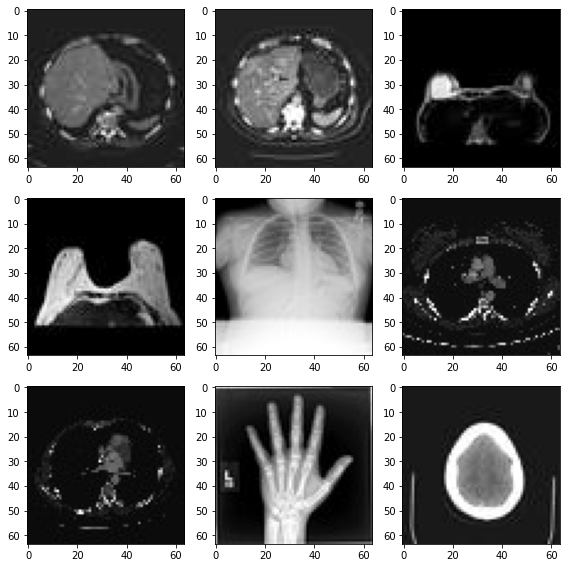

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_ds[i * 5000]["image"][0].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

### Create training components

In [8]:
device = torch.device("cuda:0")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=6).to(device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), 1e-5)

### Define the easiest training workflow and run

Use MONAI SupervisedTrainer handlers to quickly set up a training workflow.

In [9]:
trainer = SupervisedTrainer(
    device=device,
    max_epochs=5,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    inferer=SimpleInferer(),
    key_train_metric={
        "train_acc": ignite.metrics.Accuracy(
            output_transform=from_engine(["pred", "label"]))
    },
    train_handlers=StatsHandler(
        tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
)
trainer.run()

INFO:ignite.engine.engine.SupervisedTrainer:Engine run resuming from iteration 0, epoch 0 until 5 epochs
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 1/157 -- train_loss: 1.8252 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 2/157 -- train_loss: 1.7637 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 3/157 -- train_loss: 1.7338 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 4/157 -- train_loss: 1.7239 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 5/157 -- train_loss: 1.6950 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 6/157 -- train_loss: 1.6414 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 7/157 -- train_loss: 1.6280 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 8/157 -- train_loss: 1.6190 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 9/157 -- train_loss: 1.5820 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 10/157 -- trai

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 90/157 -- train_loss: 0.5009 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 91/157 -- train_loss: 0.4685 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 92/157 -- train_loss: 0.4510 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 93/157 -- train_loss: 0.4815 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 94/157 -- train_loss: 0.4358 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 95/157 -- train_loss: 0.4570 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 96/157 -- train_loss: 0.4495 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 97/157 -- train_loss: 0.4120 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 98/157 -- train_loss: 0.4414 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 99/157 -- train_loss: 0.4252 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 100/157 -- train_l

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 18/157 -- train_loss: 0.1955 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 19/157 -- train_loss: 0.1888 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 20/157 -- train_loss: 0.1706 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 21/157 -- train_loss: 0.1812 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 22/157 -- train_loss: 0.1542 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 23/157 -- train_loss: 0.1554 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 24/157 -- train_loss: 0.1728 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 25/157 -- train_loss: 0.1681 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 26/157 -- train_loss: 0.1579 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 27/157 -- train_loss: 0.1803 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 28/157 -- train_lo

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 107/157 -- train_loss: 0.1126 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 108/157 -- train_loss: 0.1096 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 109/157 -- train_loss: 0.1235 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 110/157 -- train_loss: 0.0929 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 111/157 -- train_loss: 0.0996 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 112/157 -- train_loss: 0.0982 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 113/157 -- train_loss: 0.0942 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 114/157 -- train_loss: 0.1076 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 115/157 -- train_loss: 0.0978 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 116/157 -- train_loss: 0.1017 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 2/5, Iter: 117/157 

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 35/157 -- train_loss: 0.0676 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 36/157 -- train_loss: 0.0588 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 37/157 -- train_loss: 0.0668 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 38/157 -- train_loss: 0.0736 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 39/157 -- train_loss: 0.0560 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 40/157 -- train_loss: 0.0557 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 41/157 -- train_loss: 0.0574 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 42/157 -- train_loss: 0.0946 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 43/157 -- train_loss: 0.0600 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 44/157 -- train_loss: 0.0700 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 45/157 -- train_lo

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 124/157 -- train_loss: 0.0622 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 125/157 -- train_loss: 0.0387 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 126/157 -- train_loss: 0.0620 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 127/157 -- train_loss: 0.0426 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 128/157 -- train_loss: 0.0361 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 129/157 -- train_loss: 0.0439 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 130/157 -- train_loss: 0.0472 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 131/157 -- train_loss: 0.0363 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 132/157 -- train_loss: 0.0461 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 133/157 -- train_loss: 0.0365 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 3/5, Iter: 134/157 

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 52/157 -- train_loss: 0.0413 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 53/157 -- train_loss: 0.0366 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 54/157 -- train_loss: 0.0321 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 55/157 -- train_loss: 0.0336 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 56/157 -- train_loss: 0.0469 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 57/157 -- train_loss: 0.0430 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 58/157 -- train_loss: 0.0381 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 59/157 -- train_loss: 0.0321 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 60/157 -- train_loss: 0.0414 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 61/157 -- train_loss: 0.0393 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 62/157 -- train_lo

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 141/157 -- train_loss: 0.0219 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 142/157 -- train_loss: 0.0354 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 143/157 -- train_loss: 0.0297 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 144/157 -- train_loss: 0.0222 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 145/157 -- train_loss: 0.0282 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 146/157 -- train_loss: 0.0288 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 147/157 -- train_loss: 0.0236 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 148/157 -- train_loss: 0.0301 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 149/157 -- train_loss: 0.0240 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 150/157 -- train_loss: 0.0291 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 4/5, Iter: 151/157 

INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 69/157 -- train_loss: 0.0194 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 70/157 -- train_loss: 0.0206 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 71/157 -- train_loss: 0.0259 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 72/157 -- train_loss: 0.0241 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 73/157 -- train_loss: 0.0561 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 74/157 -- train_loss: 0.0294 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 75/157 -- train_loss: 0.0353 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 76/157 -- train_loss: 0.0126 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 77/157 -- train_loss: 0.0128 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 78/157 -- train_loss: 0.0187 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 5/5, Iter: 79/157 -- train_lo

INFO:ignite.engine.engine.SupervisedTrainer:Got new best metric of train_acc: 0.9965918289098112
INFO:ignite.engine.engine.SupervisedTrainer:Epoch[5] Metrics -- train_acc: 0.9966 
INFO:ignite.engine.engine.SupervisedTrainer:Key metric: train_acc best value: 0.9965918289098112 at epoch: 5
INFO:ignite.engine.engine.SupervisedTrainer:Epoch[5] Complete. Time taken: 00:00:22
INFO:ignite.engine.engine.SupervisedTrainer:Engine run complete. Time taken: 00:01:54


## Create training experiment with DecathlonDataset and workflow

The Decathlon dataset came from [Medical Segmentation Decathlon](http://medicaldecathlon.com/) AI challenge.

### Set up pre-processing transforms

In [10]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityd(keys="image"),
        Resized(keys=["image", "label"], spatial_size=(
            32, 64, 32), mode=("trilinear", "nearest")),
        EnsureTyped(keys=["image", "label"]),
    ]
)

### Create DeccathlonDataset for training

`DecathlonDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior:
1. **root_dir**: user's local directory for caching and loading the MSD datasets.
1. **task**: which task to download and execute: one of list ("Task01_BrainTumour", "Task02_Heart", "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas", "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon").
1. **section**: expected data section, can be: `training`, `validation` or `test`.
1. **transform**: transforms to execute operations on input data. the default transform is composed by `LoadImaged` and `AddChanneld`, which can load data into numpy array with [C, H, W, D] shape.
1. **download**: whether to download and extract the Decathlon from resource link, default is False. if expected file already exists, skip downloading even set it to True. user can manually copy tar file or dataset folder to the root directory.
1. **seed**: random seed to randomly split `training`, `validation` and `test` datasets, defaut is 0.
1. **val_frac**: percentage of of validation fraction from the `training` section, default is 0.2. Decathlon data only contains `training` section with labels and `test` section without labels, so randomly select fraction from the `training` section as the `validation` section.
1. **cache_num**: number of items to be cached. Default is `sys.maxsize`. will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **cache_rate**: percentage of cached data in total, default is 1.0 (cache all). will take the minimum of (cache_num, data_length x cache_rate, data_length).
1. **num_workers**: the number of worker threads to use. if 0 a single thread will be used. Default is 0.

Note that the "tar files" are cached after a first time downloading. the `self.__getitem__()` API generates 1 `{"image": XXX, "label": XXX}` dict according to the specified index within the `self.__len__()`.

In [11]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task04_Hippocampus",
    transform=transform,
    section="training",
    download=True,
)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=32,
                          shuffle=True, num_workers=16)

Task04_Hippocampus.tar: 100%|██████████| 27.1M/27.1M [01:15<00:00, 377kB/s]


Verified 'Task04_Hippocampus.tar.part', md5: 9d24dba78a72977dbd1d2e110310f31b.
Verified 'Task04_Hippocampus.tar', md5: 9d24dba78a72977dbd1d2e110310f31b.
Verified 'Task04_Hippocampus.tar', md5: 9d24dba78a72977dbd1d2e110310f31b.


100%|██████████| 208/208 [00:34<00:00,  6.03it/s]


### Pick images from DecathlonDataset to visualize and check

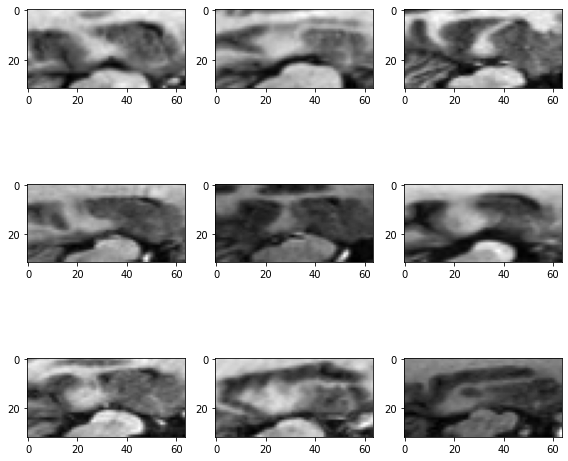

In [12]:
plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_ds[i * 20]["image"]
               [0, :, :, 10].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

### Create training components

In [13]:
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss = DiceLoss(to_onehot_y=True, softmax=True)
opt = torch.optim.Adam(net.parameters(), 1e-2)

### Define the easiest training workflow and run
Use MONAI SupervisedTrainer handlers to quickly set up a training workflow.

In [14]:
trainer = SupervisedTrainer(
    device=device,
    max_epochs=5,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    inferer=SimpleInferer(),
    postprocessing=AsDiscreted(
        keys=["pred", "label"], argmax=(True, False),
        to_onehot=3,
    ),
    key_train_metric={
        "train_meandice": MeanDice(
            output_transform=from_engine(["pred", "label"]))
    },
    train_handlers=StatsHandler(
        tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
)
trainer.run()

INFO:ignite.engine.engine.SupervisedTrainer:Engine run resuming from iteration 0, epoch 0 until 5 epochs
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 1/7 -- train_loss: 0.7959 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 2/7 -- train_loss: 0.7505 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 3/7 -- train_loss: 0.7073 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 4/7 -- train_loss: 0.6903 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 5/7 -- train_loss: 0.6436 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 6/7 -- train_loss: 0.5983 
INFO:ignite.engine.engine.SupervisedTrainer:Epoch: 1/5, Iter: 7/7 -- train_loss: 0.5609 
INFO:ignite.engine.engine.SupervisedTrainer:Got new best metric of train_meandice: 0.3706986674895653
INFO:ignite.engine.engine.SupervisedTrainer:Epoch[1] Metrics -- train_meandice: 0.3707 
INFO:ignite.engine.engine.SupervisedTrainer:Key metric: train_meandice best value:

## Share other public data and add Dataset in MONAI

Referring to the `MedNISTDataset` or `DecathlonDataset`, it's easy to create a new Dataset for other public data.  
Mainly include below steps:
1. Inherit MONAI `CacheDataset` to leverage caching mechanism to accelerate training.
1. Make sure the license of dataset allows public access and share.
1. Use `monai.apps.download_and_extract` to download and extract data in the Dataset.
1. Define the logic to randomly split `training`, `validation` and `test` sections.
1. Construct data list with `dict` items:
```py
[
    {'image': image1_path, 'label': label1_path},
    {'image': image2_path, 'label': label2_path},
    {'image': image3_path, 'label': label3_path},
    ... ...
]
```
1. Define dataset specific logic.

### Define IXIDataset as an example

Here we use the [IXI Dataset](https://brain-development.org/ixi-dataset/) as an example to show how to create a new `IXIDataset`.

In [15]:
class IXIDataset(Randomizable, CacheDataset):
    resource = "http://biomedic.doc.ic.ac.uk/" \
        + "brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    def __init__(
        self,
        root_dir,
        section,
        transform,
        download=False,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
    ):
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        dataset_dir = os.path.join(root_dir, "ixi")
        tarfile_name = f"{dataset_dir}.tar"
        if download:
            download_and_extract(
                self.resource, tarfile_name, dataset_dir, self.md5)
        # as a quick demo, we just use 10 images to show

        self.datalist = [
            {"image": os.path.join(
                dataset_dir, "IXI314-IOP-0889-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI249-Guys-1072-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI609-HH-2600-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI173-HH-1590-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI020-Guys-0700-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI342-Guys-0909-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI134-Guys-0780-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI577-HH-2661-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI066-Guys-0731-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI130-HH-1528-T1.nii.gz"), "label": 0},
        ]
        data = self._generate_data_list()
        super().__init__(
            data, transform, cache_num=cache_num,
            cache_rate=cache_rate, num_workers=num_workers,
        )

    def randomize(self, data=None):
        self.rann = self.R.random()

    def _generate_data_list(self):
        data = []
        for d in self.datalist:
            self.randomize()
            if self.section == "training":
                if self.rann < self.val_frac + self.test_frac:
                    continue
            elif self.section == "validation":
                if self.rann >= self.val_frac:
                    continue
            elif self.section == "test":
                if self.rann < self.val_frac or \
                        self.rann >= self.val_frac + self.test_frac:
                    continue
            else:
                raise ValueError(
                    f"Unsupported section: {self.section}, "
                    "available options are ['training', 'validation', 'test']."
                )
            data.append(d)
        return data

### Pick images from IXIDataset to visualize and check

Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.
file /workspace/data/medical/ixi.tar exists, skip downloading.
Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.


100%|██████████| 9/9 [00:02<00:00,  3.51it/s]


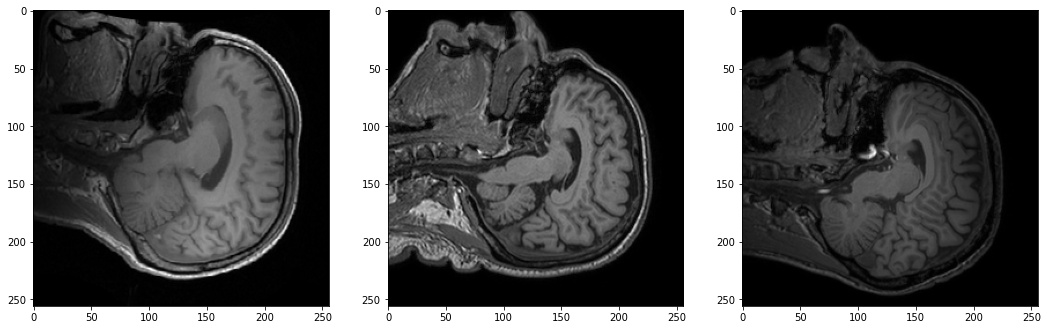

In [16]:
train_ds = IXIDataset(
    root_dir=root_dir,
    section="training",
    transform=Compose([LoadImaged("image"), EnsureTyped("image")]),
    download=True,
)
plt.figure("check", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_ds[i]["image"][:, :, 80].detach().cpu(), cmap="gray")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)